# Import required libraries

In [ ]:
pip install wordcloud

In [ ]:
pip install prophet

In [ ]:
!pip install nltk


In [ ]:
pip install statsmodels

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, classification_report
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pickle
from sklearn.linear_model import LinearRegression
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Load dataset

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#upload = files.upload()

In [3]:
# Load dataset
file_path = r'all_upwork_jobs.csv'
df = pd.read_csv(file_path)



In [5]:
# Display basic information
print(df.head())


                                               title  \
0  Experienced Media Buyer For Solar Pannel and R...   
1                               Full Stack Developer   
2                                    SMMA Bubble App   
3             Talent Hunter Specialized in Marketing   
4                                      Data Engineer   

                                                link  \
0  https://www.upwork.com/jobs/Experienced-Media-...   
1  https://www.upwork.com/jobs/Full-Stack-Develop...   
2  https://www.upwork.com/jobs/SMMA-Bubble-App_%7...   
3  https://www.upwork.com/jobs/Talent-Hunter-Spec...   
4  https://www.upwork.com/jobs/Data-Engineer_%7E0...   

              published_date  is_hourly  hourly_low  hourly_high  budget  \
0  2024-02-17 09:09:54+00:00      False         NaN          NaN   500.0   
1  2024-02-17 09:09:17+00:00      False         NaN          NaN  1100.0   
2  2024-02-17 09:08:46+00:00       True        10.0         30.0     NaN   
3  2024-02-17 09:08:08

In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244828 entries, 0 to 244827
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   title           244827 non-null  object 
 1   link            244827 non-null  object 
 2   published_date  244828 non-null  object 
 3   is_hourly       244828 non-null  bool   
 4   hourly_low      102422 non-null  float64
 5   hourly_high     98775 non-null   float64
 6   budget          103891 non-null  float64
 7   country         239751 non-null  object 
dtypes: bool(1), float64(3), object(4)
memory usage: 13.3+ MB
None


In [9]:
# Check Null Values
df.isnull().sum()

title                  1
link                   1
published_date         0
is_hourly              0
hourly_low        142406
hourly_high       146053
budget            140937
country             5077
dtype: int64

# Data Preprocessing

In [11]:
# Handle missing values

# Fill missing hourly values with the median
df['hourly_low'] = df['hourly_low'].fillna(df['hourly_low'].median())
df['hourly_high'] = df['hourly_high'].fillna(df['hourly_high'].median())

# Calculate the budget: for hourly jobs, use the average of `hourly_low` and `hourly_high`
df['budget'] = np.where(df['is_hourly'], (df['hourly_low'] + df['hourly_high']) / 2, df['budget'])

# Handle missing country values: Fill with 'Unknown'
df['country'] = df['country'].fillna('Unknown')

# Check and display the result after handling missing values
print(df[['hourly_low', 'hourly_high', 'budget', 'country']].head())

   hourly_low  hourly_high  budget        country
0        15.0         30.0   500.0        Unknown
1        15.0         30.0  1100.0  United States
2        10.0         30.0    20.0  United States
3        15.0         30.0    22.5  United States
4        15.0         30.0   650.0          India


In [13]:
# chack the missing values are left or not
df.isnull().sum()

title             1
link              1
published_date    0
is_hourly         0
hourly_low        0
hourly_high       0
budget            0
country           0
dtype: int64

In [17]:
# Now drop if still any missing value is present
df.dropna(inplace=True)

In [19]:
df.isnull().sum()

title             0
link              0
published_date    0
is_hourly         0
hourly_low        0
hourly_high       0
budget            0
country           0
dtype: int64

In [21]:
df.shape

(244827, 8)

In [23]:
# Check duplicates
df.duplicated().sum()

0

In [25]:
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [27]:
# Clean and Tokenize Job Titles

# Function to clean job titles by removing special characters, extra spaces and stopwords
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters and numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespaces
    # Tokenize the text
    words = word_tokenize(text)
    # Get English stopwords
    stop_words = set(stopwords.words('english'))
    # Filter out stopwords
    filtered_words = [word for word in words if word.lower() not in stop_words]

    # Join the words back into a string
    return ' '.join(filtered_words)

# Apply the cleaning function to the 'title' column
df['Cleaned Job Title'] = df['title'].apply(clean_text)

In [28]:
# Preview cleaned job titles
print(df[['title','Cleaned Job Title']].head())

                                               title  \
0  Experienced Media Buyer For Solar Pannel and R...   
1                               Full Stack Developer   
2                                    SMMA Bubble App   
3             Talent Hunter Specialized in Marketing   
4                                      Data Engineer   

                                   Cleaned Job Title  
0  experienced media buyer solar pannel roofing i...  
1                               full stack developer  
2                                    smma bubble app  
3                talent hunter specialized marketing  
4                                      data engineer  


In [31]:
# Tokenize job titles and count keyword frequencies
keywords = df['Cleaned Job Title'].str.split().explode()
keyword_counts = Counter(keywords)

In [33]:
# Display the top 20 most common keywords
top_keywords = keyword_counts.most_common(20)
print("Top Keywords:", top_keywords)

Top Keywords: [('needed', 17570), ('website', 16688), ('developer', 15678), ('expert', 14910), ('video', 13822), ('design', 12984), ('designer', 12603), ('need', 10223), ('amp', 9276), ('specialist', 8939), ('looking', 8730), ('marketing', 8250), ('media', 8211), ('app', 8094), ('editor', 7758), ('youtube', 7585), ('social', 7554), ('data', 7036), ('create', 6836), ('content', 6722)]


In [37]:
# Use TF-IDF for keyword significance (Top 100 features)
vectorizer = TfidfVectorizer(max_features=100)
tfidf_matrix = vectorizer.fit_transform(df['Cleaned Job Title'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

In [39]:
# Sum the TF-IDF scores for each keyword and sort
tfidf_scores = tfidf_df.sum(axis=0).sort_values(ascending=False)
print("Top TF-IDF Keywords:\n", tfidf_scores.head(20))

Top TF-IDF Keywords:
 website       9772.812697
needed        9444.140021
developer     9281.077282
expert        8639.313180
design        8245.221859
video         7653.074106
designer      7598.457257
need          6453.570560
specialist    5483.597960
looking       5325.386300
amp           5070.275897
app           4962.723557
marketing     4697.179411
editor        4559.891010
data          4479.816860
create        4432.008154
youtube       4350.566556
wordpress     4248.651227
media         4217.208311
assistant     4151.444199
dtype: float64


# Task 1: Analyze the correlation between job title keywords and offered salaries

In [41]:
# Create dictionaries for salary and example URLs for each keyword
keyword_salary = {}
keyword_urls = {}

for keyword in tfidf_scores.index:
    relevant_jobs = df[df['Cleaned Job Title'].str.contains(keyword, na=False)]
    keyword_salary[keyword] = relevant_jobs['budget'].mean()
    keyword_urls[keyword] = relevant_jobs['link'].head(3).tolist()  # Top 3 URLs

# Convert to a DataFrame for better readability
keyword_salary_df = pd.DataFrame({
    'Keyword': keyword_salary.keys(),
    'Average Salary': keyword_salary.values(),
    'Example URLs': [', '.join(urls) for urls in keyword_urls.values()]
}).sort_values(by='Average Salary', ascending=False)

# Preview the keyword-salary mapping
print(keyword_salary_df.head(10))

        Keyword  Average Salary  \
60      digital     1852.522328   
29        sales     1832.128437   
78         full     1197.821533   
77          job     1146.074854   
84      account      963.945363   
99        stack      905.407966   
27  development      869.190496   
42        build      800.367362   
65  application      764.515187   
51      seeking      701.930362   

                                         Example URLs  
60  https://www.upwork.com/jobs/Digital-Marketing-...  
29  https://www.upwork.com/jobs/Digital-Marketing-...  
78  https://www.upwork.com/jobs/Full-Stack-Develop...  
77  https://www.upwork.com/jobs/Create-job-offers-...  
84  https://www.upwork.com/jobs/Professional-Debt-...  
99  https://www.upwork.com/jobs/Full-Stack-Develop...  
27  https://www.upwork.com/jobs/Transport-Transpor...  
42  https://www.upwork.com/jobs/Build-standalone-P...  
65  https://www.upwork.com/jobs/Flutter-applicatio...  
51  https://www.upwork.com/jobs/Seeking-Creative-V... 

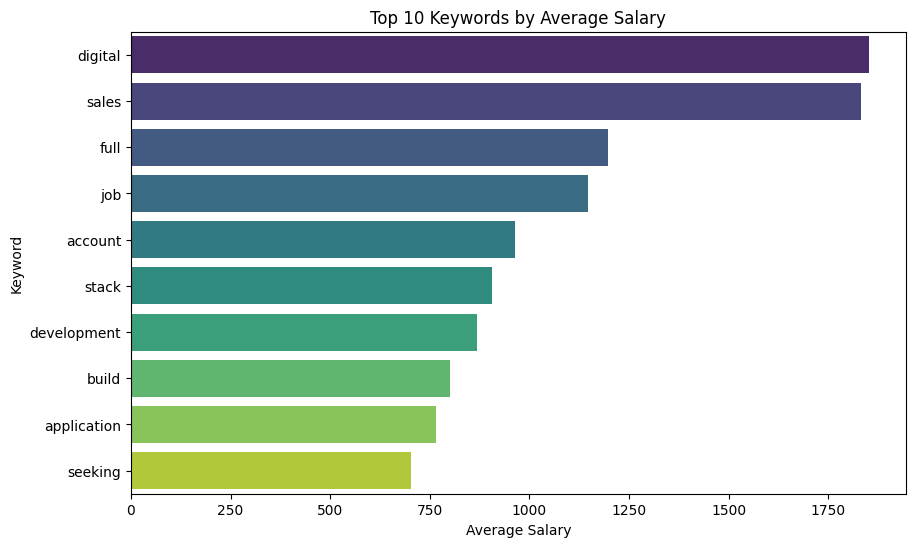

In [43]:
# Bar chart of top 10 high-paying keywords
top_10_keywords = keyword_salary_df.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(data=top_10_keywords, x='Average Salary', y='Keyword', palette='viridis')
plt.title('Top 10 Keywords by Average Salary')
plt.xlabel('Average Salary')
plt.ylabel('Keyword')
plt.show()

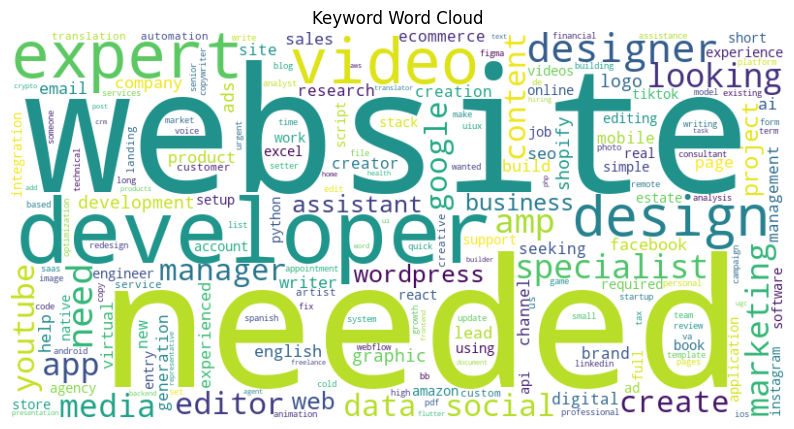

In [45]:
# Create a word cloud for the most frequent keywords
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keyword_counts)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Keyword Word Cloud')
plt.show()

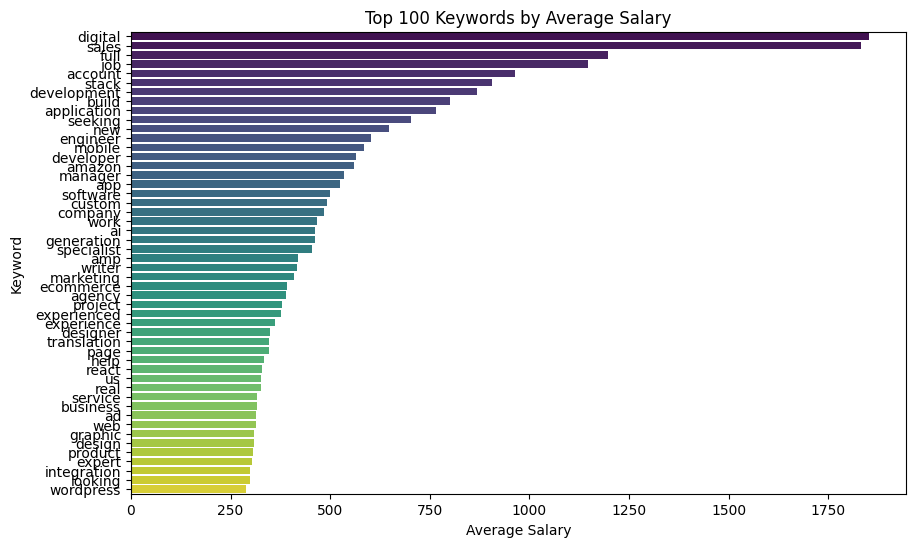

In [47]:
# Bar chart of top 50 high-paying keywords
top_50_keywords = keyword_salary_df.head(50)
plt.figure(figsize=(10, 6))
sns.barplot(data=top_50_keywords, x='Average Salary', y='Keyword', palette='viridis')
plt.title('Top 100 Keywords by Average Salary')
plt.xlabel('Average Salary')
plt.ylabel('Keyword')
plt.show()

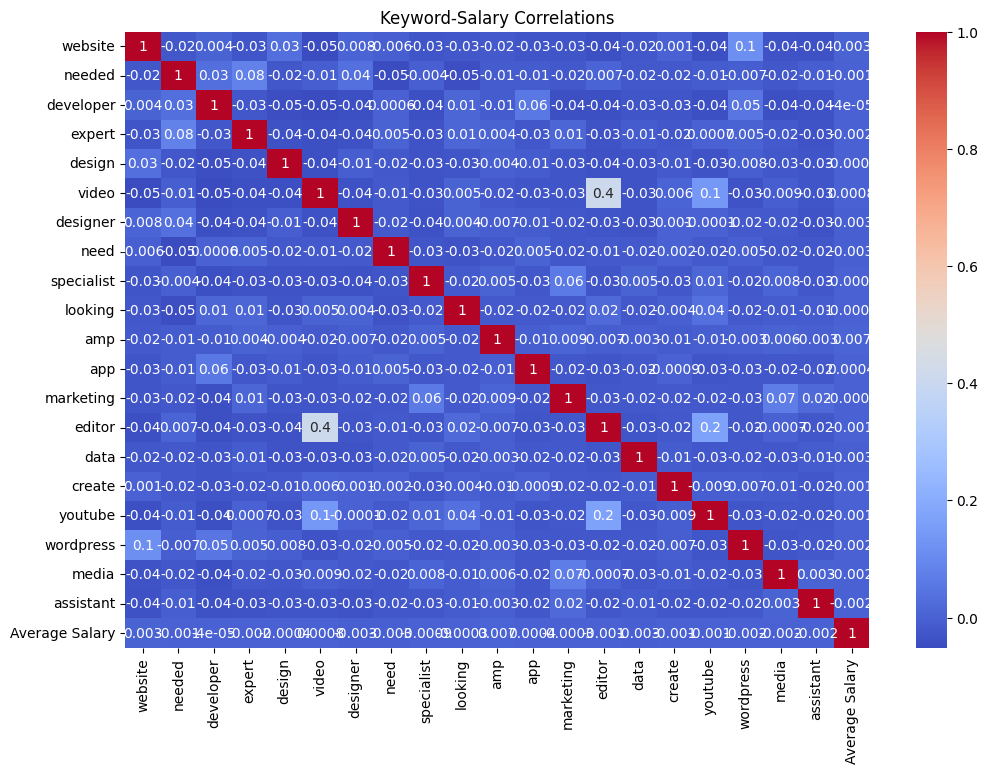

In [49]:
# Select top 20 keywords for correlation analysis
selected_keywords = tfidf_scores.index[:20]
selected_keyword_df = tfidf_df[selected_keywords]
selected_keyword_df['Average Salary'] = df['budget']

# Generate a heatmap showing the correlation between keywords and salaries
plt.figure(figsize=(12, 8))
sns.heatmap(selected_keyword_df.corr(), annot=True, cmap='coolwarm',fmt='0.1g')
plt.title('Keyword-Salary Correlations')
plt.show()

In [51]:
# Export keyword-salary data to a CSV file
keyword_salary_df.to_csv('keyword_salary_analysis_with_urls.csv', index=False)

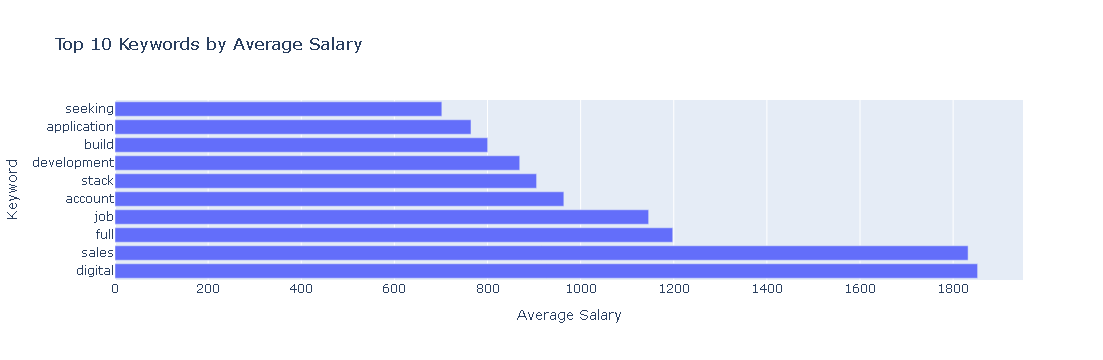

In [53]:
import plotly.express as px

# Add URLs to the DataFrame for hover text
top_10_keywords['URLs'] = top_10_keywords['Example URLs']

# Create an interactive bar plot using Plotly
fig = px.bar(
    top_10_keywords,
    x='Average Salary',
    y='Keyword',
    hover_data=['URLs'],  # Show URLs on hover
    title='Top 10 Keywords by Average Salary',
    orientation='h'
)
fig.show()

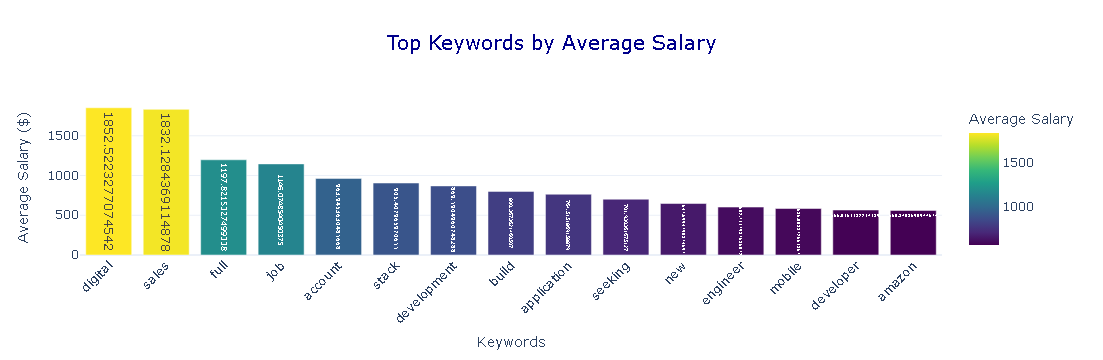

In [55]:
# Prepare the data: Top 15 keywords by average salary
top_keywords = keyword_salary_df.head(15)

# Add a custom hover text to display example URLs
top_keywords['Hover Text'] = (
    'Keyword: ' + top_keywords['Keyword'] +
    '<br>Average Salary: $' + top_keywords['Average Salary'].round(2).astype(str) +
    '<br>Example URLs: ' + top_keywords['Example URLs']
)

# Create the interactive bar chart
fig = px.bar(
    top_keywords,
    x='Keyword',
    y='Average Salary',
    text='Average Salary',
    title='Top Keywords by Average Salary',
    hover_name='Hover Text',
    color='Average Salary',
    color_continuous_scale=px.colors.sequential.Viridis,
)

# Customize the layout for better visuals
fig.update_layout(
    title_font_size=20,
    title_font_color='darkblue',
    title_x=0.5,  # Center the title
    xaxis_title='Keywords',
    yaxis_title='Average Salary ($)',
    xaxis_tickangle=-45,
    template='plotly_white',
)

# Display the figure
fig.show()

# Task 2: Identify Emerging Job Categories Based on Posting Frequency

In [57]:
df.head(2)

,title,link,published_date,is_hourly,hourly_low,hourly_high,budget,country,Cleaned Job Title
0,Experienced Media Buyer For Solar Pannel and R...,https://www.upwork.com/jobs/Experienced-Media-...,2024-02-17 09:09:54+00:00,False,15.0,30.0,500.0,Unknown,experienced media buyer solar pannel roofing i...
1,Full Stack Developer,https://www.upwork.com/jobs/Full-Stack-Develop...,2024-02-17 09:09:17+00:00,False,15.0,30.0,1100.0,United States,full stack developer


In [59]:
# Define job categories and relevant keywords
def map_to_category(title):
    title = title.lower()
    if any(word in title for word in ['developer', 'software', 'engineer', 'programmer', 'devops', 'backend', 'frontend', 'full stack']):
        return 'Software Development'
    elif any(word in title for word in ['data', 'machine learning', 'ai', 'analytics', 'science', 'big data']):
        return 'Data Science'
    elif any(word in title for word in ['designer', 'ui', 'ux', 'graphic', 'visual', 'motion']):
        return 'Design'
    elif any(word in title for word in ['marketing', 'seo', 'advertising', 'campaign', 'social media']):
        return 'Marketing'
    elif any(word in title for word in ['writer', 'content', 'editor', 'author', 'translator', 'copywriter']):
        return 'Writing'
    elif any(word in title for word in ['manager', 'management', 'pm', 'product owner', 'scrum']):
        return 'Project Management'
    elif any(word in title for word in ['customer', 'support', 'service', 'client', 'helpdesk']):
        return 'Customer Support'
    elif any(word in title for word in ['sales', 'business development', 'account', 'growth']):
        return 'Sales'
    elif any(word in title for word in ['finance', 'accounting', 'bookkeeper', 'financial']):
        return 'Finance'
    elif any(word in title for word in ['legal', 'lawyer', 'attorney', 'paralegal']):
        return 'Legal'
    elif any(word in title for word in ['teacher', 'trainer', 'tutor', 'educator']):
        return 'Education'
    else:
        return 'Other'

In [61]:
# Apply mapping function to create the 'Category' column
df['Category'] = df['title'].apply(map_to_category)
df['Category'].value_counts()

Category
Other                   112168
Design                   28093
Data Science             26585
Software Development     22288
Writing                  16878
Marketing                15390
Project Management        9303
Sales                     6409
Customer Support          4238
Legal                     1332
Finance                   1294
Education                  849
Name: count, dtype: int64

In [63]:
# Preview the categorized dataset
print(df[['Cleaned Job Title', 'Category']].head())

                                   Cleaned Job Title              Category
0  experienced media buyer solar pannel roofing i...                 Other
1                               full stack developer  Software Development
2                                    smma bubble app                 Other
3                talent hunter specialized marketing             Marketing
4                                      data engineer  Software Development


In [65]:
# Convert 'published_date' to datetime format
df['published_date'] = pd.to_datetime(df['published_date'])

In [67]:
# Extract the year and month for grouping
df['YearMonth'] = df['published_date'].dt.to_period('M')

In [69]:
# Count the number of job postings per category for each month
job_trends = df.groupby(['YearMonth', 'Category']).size().reset_index(name='Job Count')

In [71]:
# Pivot the data for better visualization
job_trends_pivot = job_trends.pivot(index='YearMonth', columns='Category', values='Job Count').fillna(0)

In [73]:
# Preview the trends data
print(job_trends_pivot.tail())

Category   Customer Support  Data Science   Design  Education  Finance  Legal  \
YearMonth                                                                       
2023-11                 0.0           0.0      0.0        0.0      0.0    0.0   
2023-12                 0.0           2.0      1.0        0.0      0.0    0.0   
2024-01                 7.0           8.0      6.0        0.0      1.0    1.0   
2024-02              1721.0       11335.0  11644.0      354.0    547.0  554.0   
2024-03              2510.0       15240.0  16442.0      495.0    746.0  777.0   

Category   Marketing    Other  Project Management   Sales  \
YearMonth                                                   
2023-11          0.0      1.0                 0.0     0.0   
2023-12          1.0      2.0                 0.0     1.0   
2024-01          6.0     35.0                 9.0     8.0   
2024-02       6271.0  46444.0              3799.0  2650.0   
2024-03       9112.0  65686.0              5495.0  3750.0   

Cate

In [75]:
# Calculate the percentage change in job counts month-over-month for each category
job_trends_pivot_growth = job_trends_pivot.pct_change().fillna(0)

In [77]:
# Average growth rate over the period for each category
average_growth = job_trends_pivot_growth.mean().sort_values(ascending=False)

In [79]:
# Display the top emerging categories
print("Ranked List of Emerging Categories:")
print(average_growth)

Ranked List of Emerging Categories:
Category
Customer Support               inf
Data Science                   inf
Design                         inf
Education                      inf
Finance                        inf
Legal                          inf
Marketing                      inf
Project Management             inf
Sales                          inf
Software Development           inf
Writing                        inf
Other                   268.777147
dtype: float64


In [81]:
# Separate categories with inf growth rates
new_categories = average_growth[average_growth == float('inf')].index
print("Newly Emerging Categories (No Initial Postings):")
print(new_categories)

Newly Emerging Categories (No Initial Postings):
Index(['Customer Support', 'Data Science', 'Design', 'Education', 'Finance',
       'Legal', 'Marketing', 'Project Management', 'Sales',
       'Software Development', 'Writing'],
      dtype='object', name='Category')


In [83]:
# Adjust the growth rate calculation to handle zero counts
job_trends_pivot_growth = job_trends_pivot.pct_change().fillna(0).replace([float('inf'), -float('inf')], 0)

# Recalculate average growth rates
modified_average_growth = job_trends_pivot_growth.mean().sort_values(ascending=False)

# Display the adjusted results
print("Adjusted Ranked List of Emerging Categories:")
print(modified_average_growth)

Adjusted Ranked List of Emerging Categories:
Category
Design                  389.015745
Writing                 373.767944
Data Science            283.843902
Other                   268.777147
Marketing               209.923941
Software Development    165.162870
Legal                   110.680505
Finance                 109.272761
Project Management       84.311509
Sales                    67.533019
Customer Support         49.063119
Education                 0.079661
dtype: float64


In [85]:
# Select top 5 categories by average growth
top_categories = modified_average_growth.head(5).index

In [87]:
# Convert YearMonth (Period) index to datetime format for Matplotlib
#job_trends_pivot.index = job_trends_pivot.index.to_timestamp() # This line is causing the error
# Since the index is already a DatetimeIndex, no further conversion is needed.
# The code can continue as is, or you can add a check to only convert if it's not already a DatetimeIndex:
if not isinstance(job_trends_pivot.index, pd.DatetimeIndex):
    job_trends_pivot.index = job_trends_pivot.index.to_timestamp()

In [89]:
# Convert YearMonth (Period) index to datetime format for Matplotlib
#job_trends_pivot.index = job_trends_pivot.index.to_timestamp()

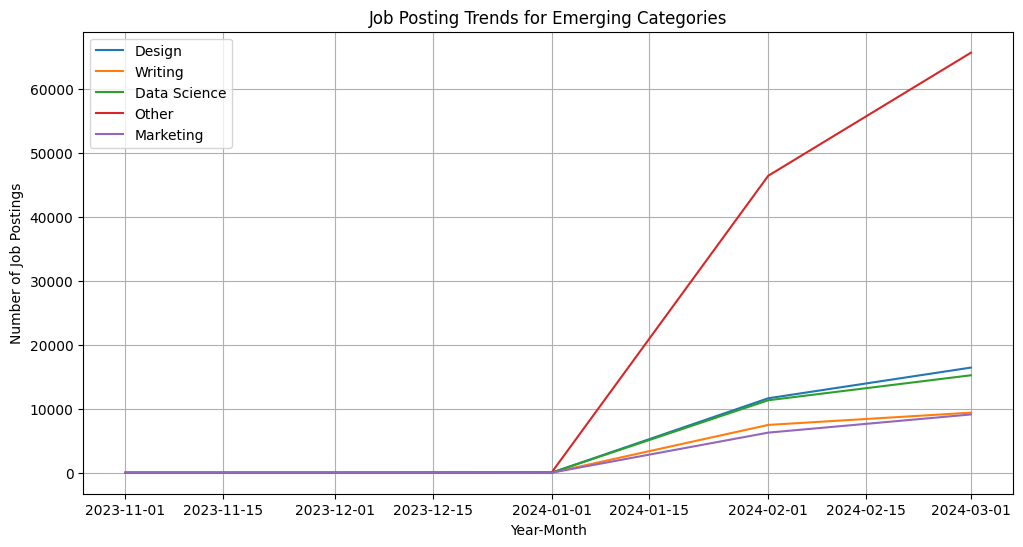

In [91]:
# Plot job trends for the top categories
plt.figure(figsize=(12, 6))
for category in top_categories:
    plt.plot(job_trends_pivot.index, job_trends_pivot[category], label=category)

plt.title('Job Posting Trends for Emerging Categories')
plt.xlabel('Year-Month')
plt.ylabel('Number of Job Postings')
plt.legend()
plt.grid()
plt.show()

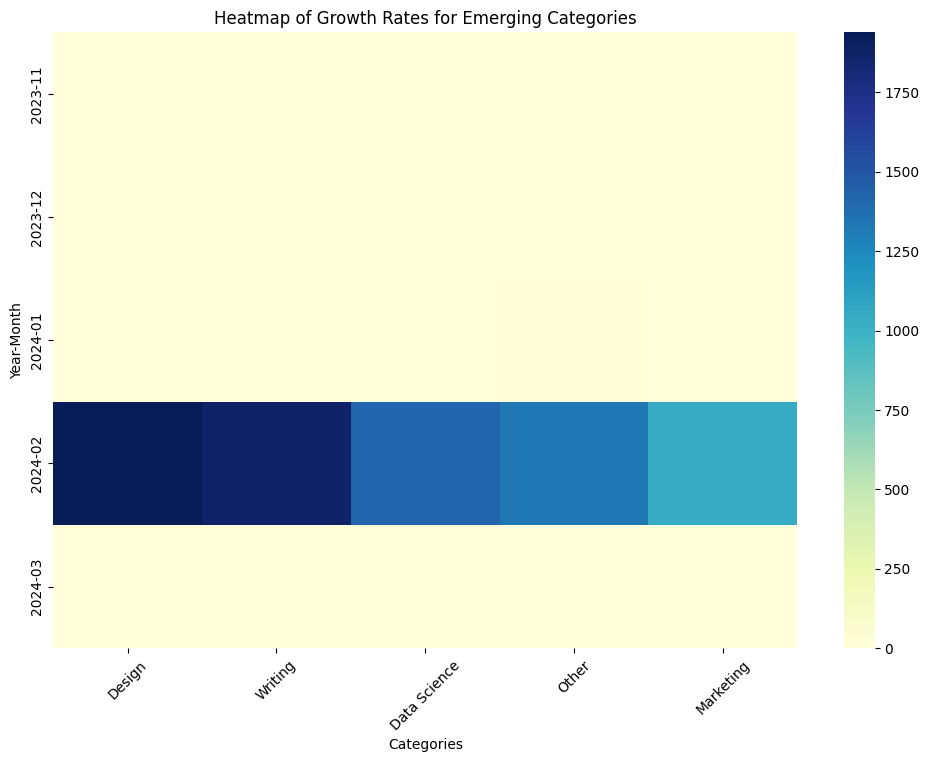

In [93]:
# Plot a heatmap of growth rates for all categories
plt.figure(figsize=(12, 8))
sns.heatmap(job_trends_pivot_growth[top_categories], cmap='YlGnBu', annot=False)
plt.title('Heatmap of Growth Rates for Emerging Categories')
plt.xlabel('Categories')
plt.ylabel('Year-Month')
plt.xticks(rotation=45)
plt.show()

# Task 3: Predict high-demand job roles by analyzing job posting patterns over time

In [95]:
# Define high-demand roles based on the top 25% threshold
job_counts = df.groupby(['YearMonth', 'Category']).size().reset_index(name='PostingCount')
threshold = job_counts['PostingCount'].quantile(0.75)
job_counts['HighDemand'] = (job_counts['PostingCount'] > threshold).astype(int)

In [97]:
# Merge back to main dataset
merged_data = df.merge(job_counts[['YearMonth', 'Category', 'HighDemand']],
                                on=['YearMonth', 'Category'], how='left')

print("Sample Data with High-Demand Labels:")
print(merged_data[['YearMonth', 'Category', 'HighDemand']].head())

Sample Data with High-Demand Labels:
  YearMonth              Category  HighDemand
0   2024-02                 Other           1
1   2024-02  Software Development           1
2   2024-02                 Other           1
3   2024-02             Marketing           0
4   2024-02  Software Development           1


In [99]:
# Lag features for historical trends
for lag in range(1, 4):
    merged_data[f'Lag_{lag}'] = merged_data.groupby('Category')['HighDemand'].shift(lag)

In [101]:
# Fill missing values
merged_data.fillna(0, inplace=True)

In [103]:
# Select relevant columns
features = ['Lag_1', 'Lag_2', 'Lag_3']
target = 'HighDemand'

In [105]:
# Prepare training data
X = merged_data[features]
y = merged_data[target]

In [107]:
# Split into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [109]:
# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [111]:
# Predictions and evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 1.00
Precision: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5963
           1       1.00      1.00      1.00     43003

    accuracy                           1.00     48966
   macro avg       0.99      0.99      0.99     48966
weighted avg       1.00      1.00      1.00     48966



In [113]:
# Aggregate data for visualization
demand_trends = merged_data.groupby(['YearMonth', 'Category'])['HighDemand'].mean().unstack()

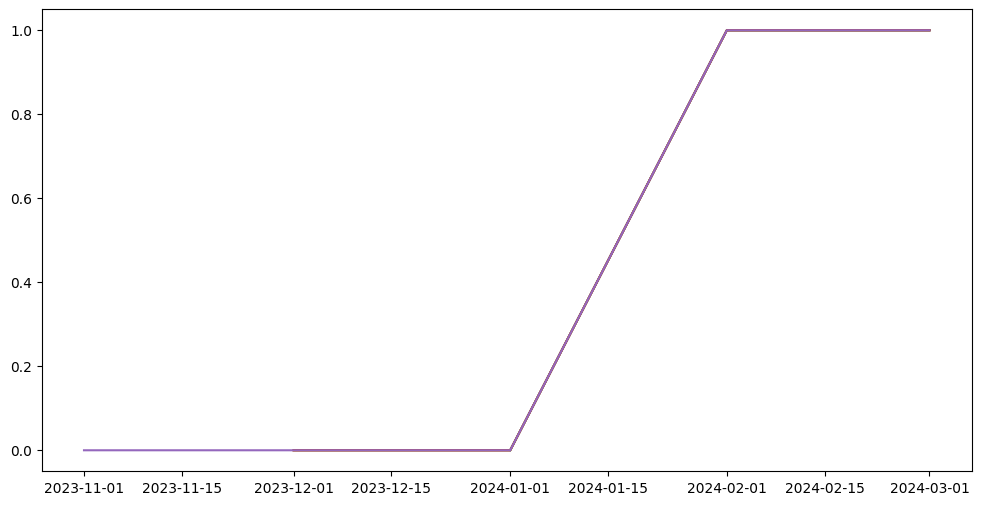

In [115]:
# Plot demand trends for the top categories
top_categories = demand_trends.mean().sort_values(ascending=False).head(5).index
plt.figure(figsize=(12, 6))
for category in top_categories:
    plt.plot(demand_trends.index.to_timestamp(), demand_trends[category], label=category)

In [117]:
# Ensure index is in datetime format for plotting
demand_trends.index = demand_trends.index.to_timestamp()

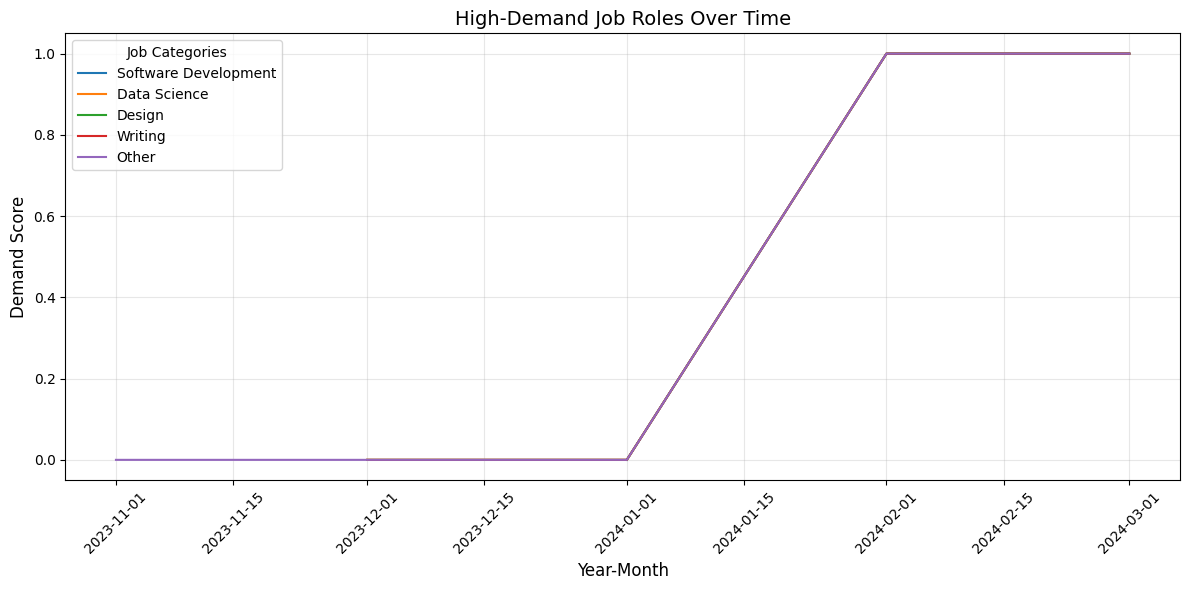

In [119]:
plt.figure(figsize=(12, 6))

for category in top_categories:
    if category in demand_trends.columns:
        plt.plot(demand_trends.index, demand_trends[category], label=category)

# Add title, labels, and legend
plt.title('High-Demand Job Roles Over Time', fontsize=14)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Demand Score', fontsize=12)
plt.legend(title="Job Categories", fontsize=10)
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [121]:
# Recheck demand score normalization
demand_trends_normalized = demand_trends.div(demand_trends.max(axis=0), axis=1)


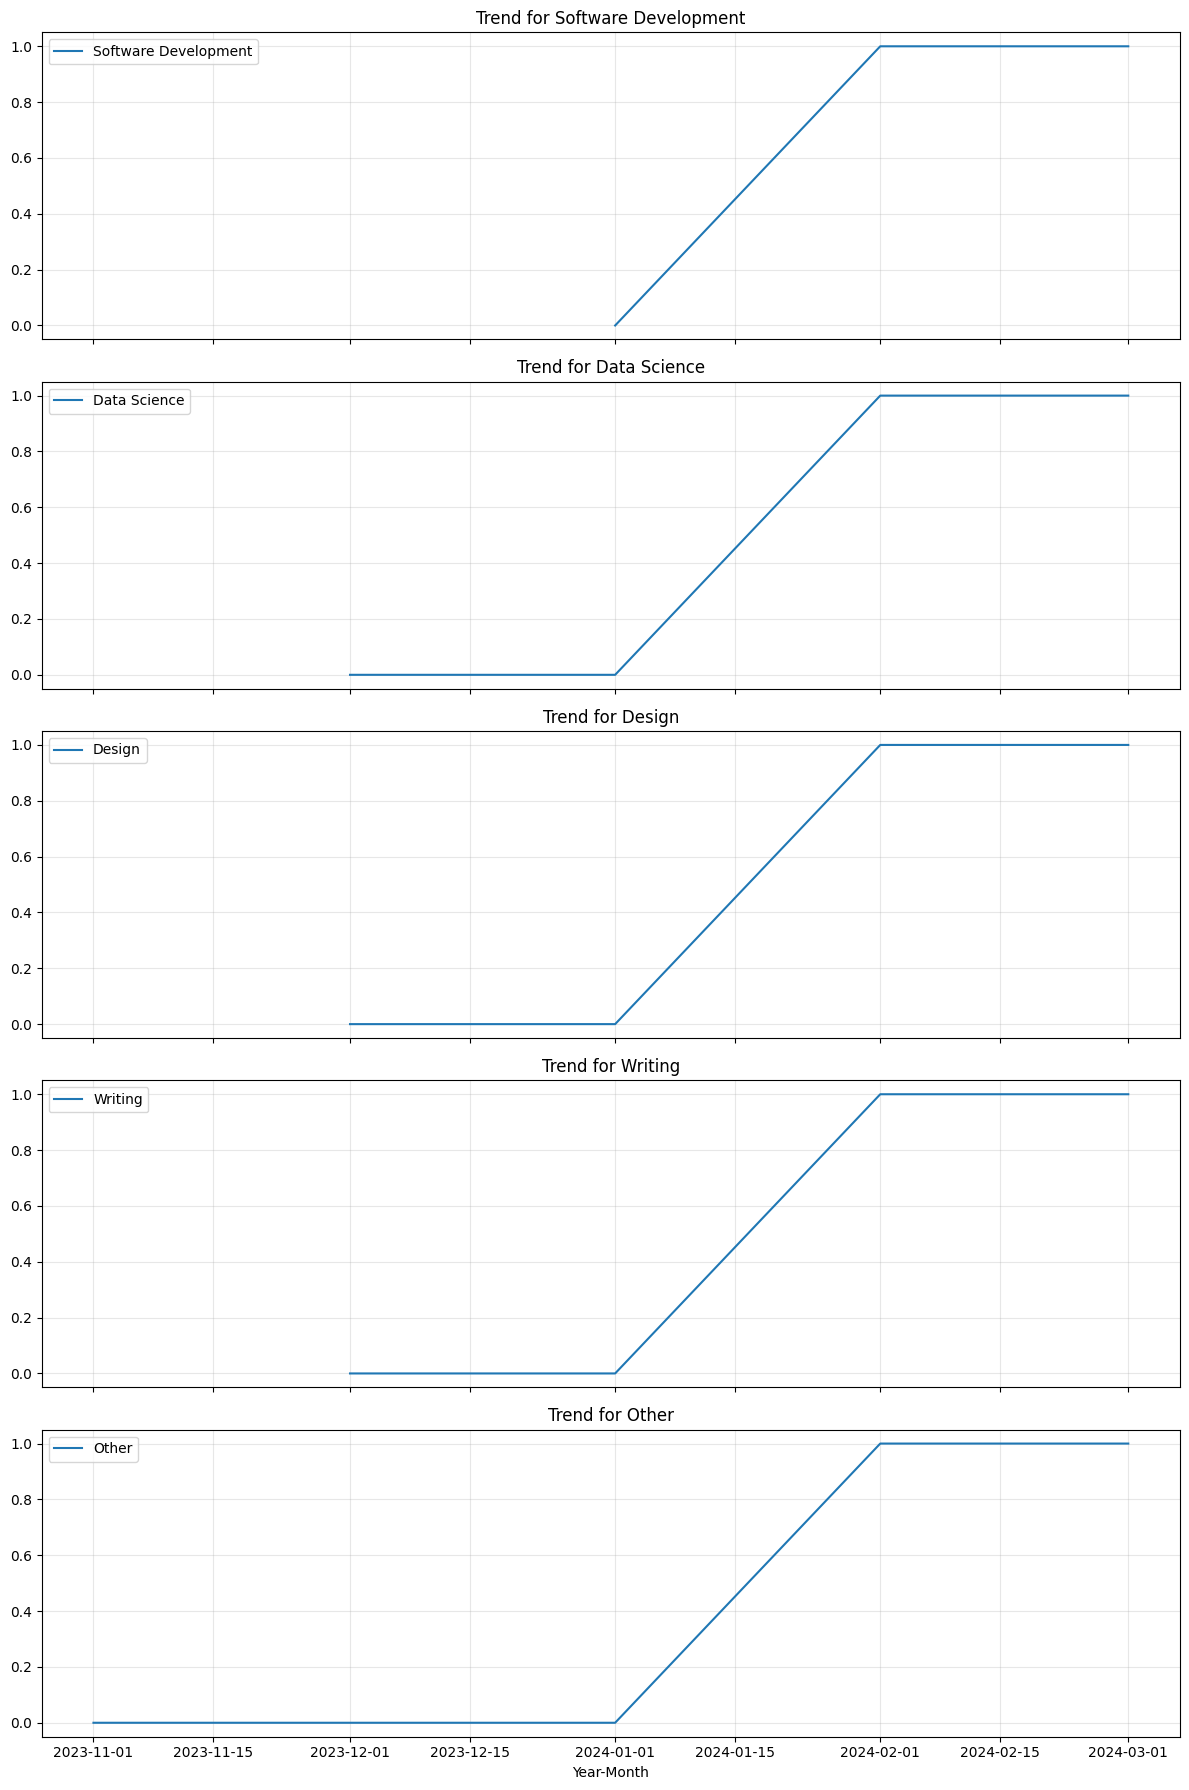

In [123]:
fig, ax = plt.subplots(len(top_categories), 1, figsize=(12, 18), sharex=True)
for i, category in enumerate(top_categories):
    ax[i].plot(demand_trends.index, demand_trends[category], label=category)
    ax[i].set_title(f'Trend for {category}')
    ax[i].grid(alpha=0.3)
    ax[i].legend()

plt.xlabel('Year-Month')
plt.tight_layout()
plt.show()


# Task 4: Compare average hourly rates across different countries

In [125]:
# Ensure hourly rates are calculated
df['average_hourly_rate'] = df[['hourly_low', 'hourly_high']].mean(axis=1)

In [127]:
# Filter out rows with missing or zero values in 'average_hourly_rate' or 'country'
df_geo = df[(df['average_hourly_rate'].notna()) & (df['average_hourly_rate'] > 0) & (df['country'].notna())]

In [129]:
# Group by country and calculate the average hourly rate
country_salary = (
    df_geo.groupby('country')['average_hourly_rate']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

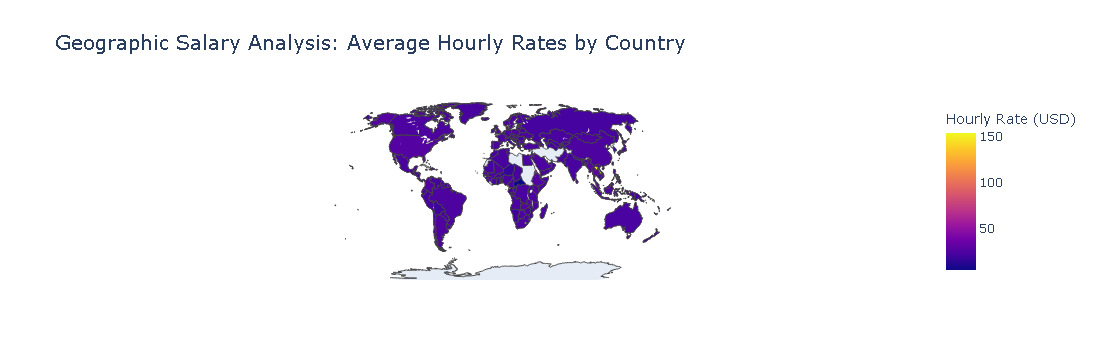

In [131]:
# Interactive Visualization with Plotly
import plotly.express as px

fig = px.choropleth(
    country_salary,
    locations="country",
    locationmode="country names",
    color="average_hourly_rate",
    title="Geographic Salary Analysis: Average Hourly Rates by Country",
    color_continuous_scale="Plasma",
    labels={'average_hourly_rate': 'Avg Hourly Rate (USD)'}
)

fig.update_layout(
    geo=dict(showframe=False, projection_type="natural earth"),
    title_font_size=20,
    coloraxis_colorbar=dict(title="Hourly Rate (USD)")
)

fig.show()

In [133]:
# Display the top and bottom 10 countries for hourly wages
print("Top 10 countries with highest wages:")
print(country_salary.head(10))

print("\nBottom 10 countries with lowest wages:")
print(country_salary.tail(10))

Top 10 countries with highest wages:
                    country  average_hourly_rate
0                      Laos           155.125000
1                   Eritrea            61.250000
2  Turks and Caicos Islands            46.625000
3                    Malawi            42.375000
4      Netherlands Antilles            35.416667
5             Liechtenstein            35.000000
6             French Guiana            34.000000
7                  Malaysia            31.661130
8                  Thailand            30.319061
9    British Virgin Islands            29.145833

Bottom 10 countries with lowest wages:
                                  country  average_hourly_rate
203                      French Polynesia            19.029412
204  United States Minor Outlying Islands            18.750000
205                            Guadeloupe            18.428571
206                              Holy See            17.500000
207                                 Aruba            17.263158
208   

# Task 5: Create a job recommendation engine based on current job postings

In [135]:
# Combine important columns to create job description vectors
df['job_description'] = df['title'] + " " + df['country'] + " " + df['is_hourly'].astype(str)

In [137]:
# Fill missing values in 'job_description'
df['job_description'] = df['job_description'].fillna('')

In [139]:
# Use TfidfVectorizer to encode job descriptions
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
job_vectors = vectorizer.fit_transform(df['job_description'])

In [141]:
# Save the model
with open("jma&rs_model.pkl", "wb") as file:
    pickle.dump(vectorizer, file)

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 244827 entries, 0 to 244827
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   title                244827 non-null  object             
 1   link                 244827 non-null  object             
 2   published_date       244827 non-null  datetime64[ns, UTC]
 3   is_hourly            244827 non-null  bool               
 4   hourly_low           244827 non-null  float64            
 5   hourly_high          244827 non-null  float64            
 6   budget               244827 non-null  float64            
 7   country              244827 non-null  object             
 8   Cleaned Job Title    244827 non-null  object             
 9   Category             244827 non-null  object             
 10  YearMonth            244827 non-null  period[M]          
 11  average_hourly_rate  244827 non-null  float64            
 12  job_des

In [145]:
# Add dummy user profile for demonstration
user_profile = {
    'preferred_title': 'Data Scientist',
    'preferred_country': 'United States',
    'preferred_hourly': True
}

In [147]:
# Create a dummy user vector based on preferences
user_vector_input = (
    user_profile['preferred_title']
    + " " + user_profile['preferred_country']
    + " " + str(user_profile['preferred_hourly'])
)
user_vector = vectorizer.transform([user_vector_input])

In [149]:
# Compute cosine similarity between the user and all job postings
similarity_scores = cosine_similarity(user_vector, job_vectors).flatten()

In [151]:
# Add similarity scores to the dataframe
df['similarity_score'] = similarity_scores

In [153]:
# Retrieve the top 10 recommended jobs for the user
top_recommendations = df.sort_values(by='similarity_score', ascending=False).head(10)
print("Top 10 Job Recommendations:")
print(top_recommendations[['title', 'country', 'similarity_score']])

Top 10 Job Recommendations:
                 title         country  similarity_score
52859   Data Scientist   United States          1.000000
20017   Data Scientist   United States          1.000000
99592   Data Scientist   United States          1.000000
192080  Data Scientist   United States          1.000000
236871  Data Scientist   United States          1.000000
217927  Data Scientist   United States          1.000000
14460   Data Scientist   United States          0.969423
44791   Data Scientist   United States          0.969423
174846  Data Scientist   United States          0.969423
101541  Data Scientist  United Kingdom          0.919806


In [155]:
df.to_csv('job_posting.csv',index=False)

# Task 7: investigate trends in the remote work landscape

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 244827 entries, 0 to 244827
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   title                244827 non-null  object             
 1   link                 244827 non-null  object             
 2   published_date       244827 non-null  datetime64[ns, UTC]
 3   is_hourly            244827 non-null  bool               
 4   hourly_low           244827 non-null  float64            
 5   hourly_high          244827 non-null  float64            
 6   budget               244827 non-null  float64            
 7   country              244827 non-null  object             
 8   Cleaned Job Title    244827 non-null  object             
 9   Category             244827 non-null  object             
 10  YearMonth            244827 non-null  period[M]          
 11  average_hourly_rate  244827 non-null  float64            
 12  job_des

In [159]:
# Identify Remote Jobs
df['is_remote'] = df['job_description'].str.contains(
    'remote|work from home|telecommute|online', case=False, na=False
)

In [161]:
# Compute Monthly Trends for Remote Jobs
df['YearMonth'] = df['published_date'].dt.to_period('M')  # Extract Year-Month
monthly_remote_trends = df.groupby('YearMonth')['is_remote'].mean() * 100

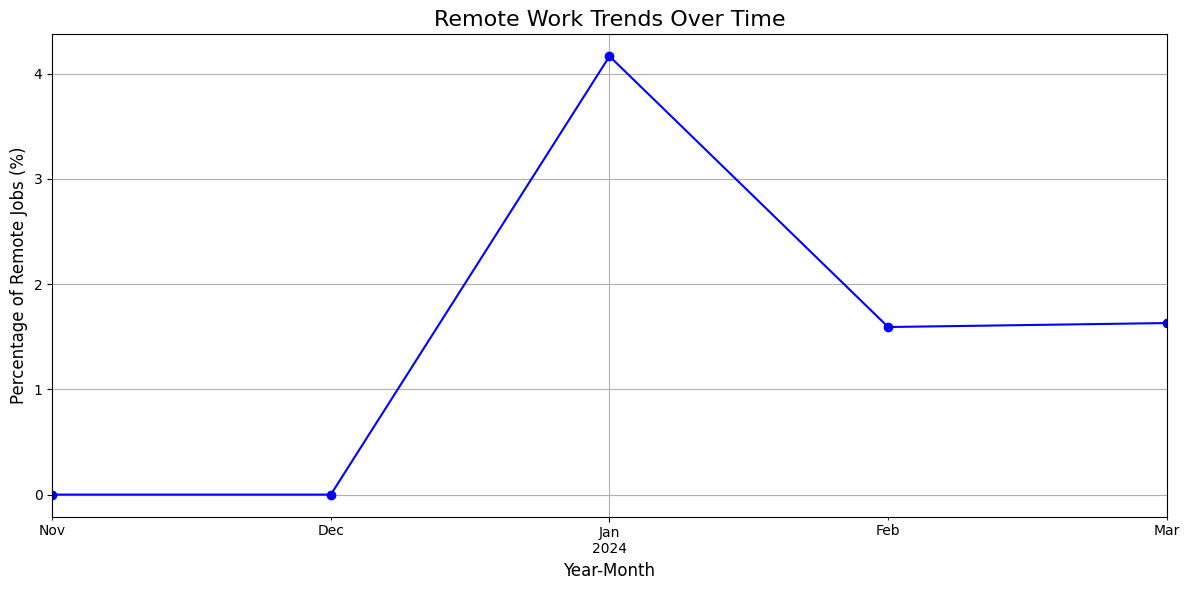

In [163]:
# Visualize Remote Work Trends Over Time
plt.figure(figsize=(12, 6))
monthly_remote_trends.plot(kind='line', marker='o', color='blue')
plt.title("Remote Work Trends Over Time", fontsize=16)
plt.xlabel("Year-Month", fontsize=12)
plt.ylabel("Percentage of Remote Jobs (%)", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig("remote_work_trends.png")
plt.show()

In [165]:
# Forecast Future Trends

# Prepare data for regression
monthly_remote_trends_df = monthly_remote_trends.reset_index()
monthly_remote_trends_df['YearMonth_num'] = monthly_remote_trends_df['YearMonth'].apply(
    lambda x: x.to_timestamp().toordinal()
)
X = monthly_remote_trends_df[['YearMonth_num']]
y = monthly_remote_trends_df['is_remote']

In [167]:
# Train the regression model
model = LinearRegression()
model.fit(X, y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [169]:
# Predict for the next 12 months
last_date = df['published_date'].max()
future_dates = pd.date_range(
    start=last_date + pd.offsets.MonthBegin(), periods=12, freq='M'
)
future_dates_ordinal = future_dates.map(lambda x: x.toordinal()).values.reshape(-1, 1)
future_predictions = model.predict(future_dates_ordinal)

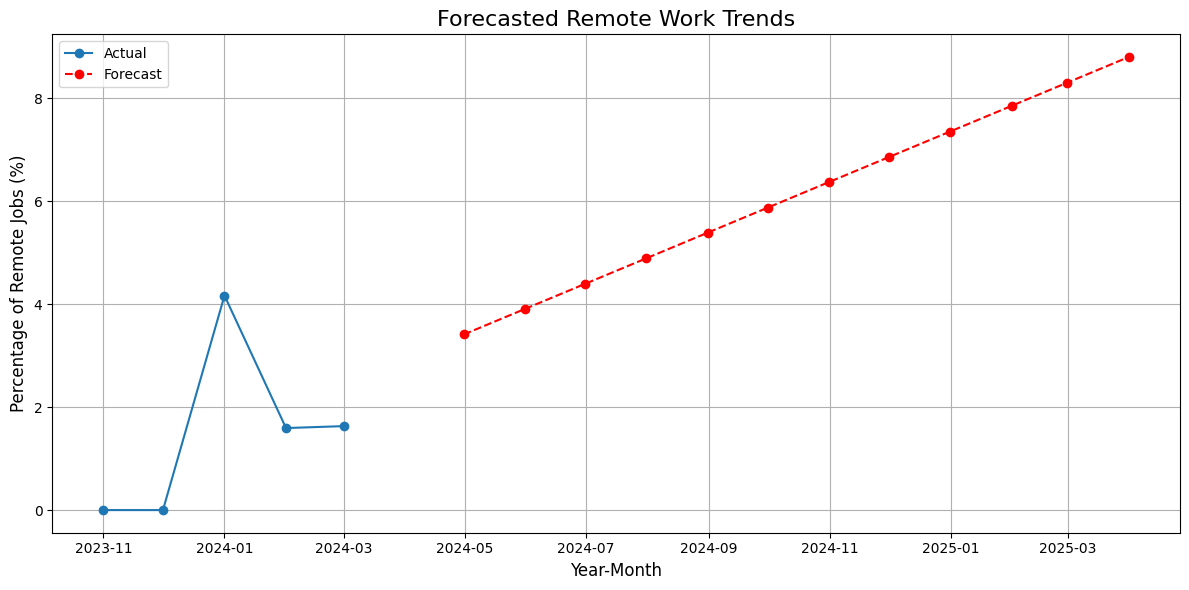

In [171]:
# Plot historical and forecasted trends
plt.figure(figsize=(12, 6))
plt.plot(monthly_remote_trends.index.to_timestamp(), monthly_remote_trends, marker='o', label="Actual")
plt.plot(future_dates, future_predictions, linestyle='--', marker='o', color='red', label="Forecast")
plt.title("Forecasted Remote Work Trends", fontsize=16)
plt.xlabel("Year-Month", fontsize=12)
plt.ylabel("Percentage of Remote Jobs (%)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("forecasted_remote_work_trends.png")
plt.show()

In [173]:
# Step 5: Summarize Insights
remote_rate = df['is_remote'].mean() * 100
print(f"Overall Remote Work Rate: {remote_rate:.2f}%")

recent_trends = monthly_remote_trends.tail(12)
forecasted_trends = dict(zip(future_dates.strftime('%Y-%m'), future_predictions))

print("\nRecent Monthly Trends:")
print(recent_trends)

print("\nForecasted Trends:")
for date, prediction in forecasted_trends.items():
    print(f"{date}: {prediction:.2f}%")

Overall Remote Work Rate: 1.62%

Recent Monthly Trends:
YearMonth
2023-11    0.000000
2023-12    0.000000
2024-01    4.166667
2024-02    1.592957
2024-03    1.630564
Freq: M, Name: is_remote, dtype: float64

Forecasted Trends:
2024-04: 3.41%
2024-05: 3.91%
2024-06: 4.39%
2024-07: 4.89%
2024-08: 5.39%
2024-09: 5.87%
2024-10: 6.37%
2024-11: 6.85%
2024-12: 7.35%
2025-01: 7.85%
2025-02: 8.30%
2025-03: 8.80%


In [175]:
 # Save Analysis as a Report
report = f"""
Remote Work Trends Analysis Report
==================================
Overall Remote Work Rate: {remote_rate:.2f}%

Recent Monthly Trends:
{recent_trends}

Forecasted Remote Work Trends:
{"-"*40}
Month            Forecasted Remote Job Rate (%)
{"-"*40}
""" + "\n".join([f"{date}: {prediction:.2f}%" for date, prediction in forecasted_trends.items()])

with open("remote_work_trends_report.txt", "w") as file:
    file.write(report)

print("\nReport saved as 'remote_work_trends_report.txt'")


Report saved as 'remote_work_trends_report.txt'


# Sentiment Analysis

In [177]:
# Initialize Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

In [179]:
# maka data for further use
data = df

In [181]:
# Apply sentiment analysis on job descriptions
data['sentiment_score'] = data['job_description'].apply(lambda x: sia.polarity_scores(x)['compound'])
data['sentiment_label'] = data['sentiment_score'].apply(
    lambda x: 'Positive' if x > 0.05 else ('Negative' if x < -0.05 else 'Neutral')
)

In [183]:
# Sentiment distribution
sentiment_distribution = data['sentiment_label'].value_counts()
print("Sentiment Distribution:")
print(sentiment_distribution)

Sentiment Distribution:
sentiment_label
Positive    196602
Neutral      46435
Negative      1790
Name: count, dtype: int64


In [185]:
# Save sentiment distribution
sentiment_distribution.to_csv("sentiment_distribution.csv", index=True)

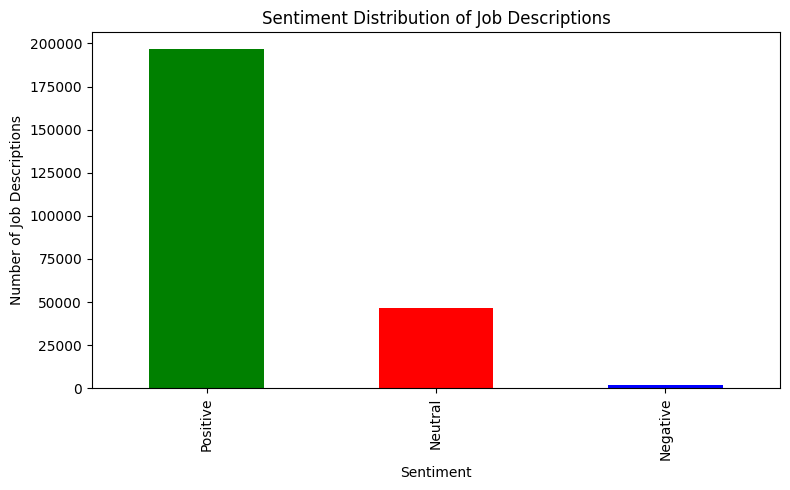

In [187]:
# Visualization
plt.figure(figsize=(8, 5))
sentiment_distribution.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Sentiment Distribution of Job Descriptions')
plt.xlabel('Sentiment')
plt.ylabel('Number of Job Descriptions')
plt.tight_layout()
plt.savefig("sentiment_distribution.png")
plt.show()

## Trends by Job Category

In [189]:
# Remote job trends per category
category_remote_trends = (
    data.groupby(['Category', 'YearMonth'])['is_remote']
    .mean()
    .unstack(level=0)
)

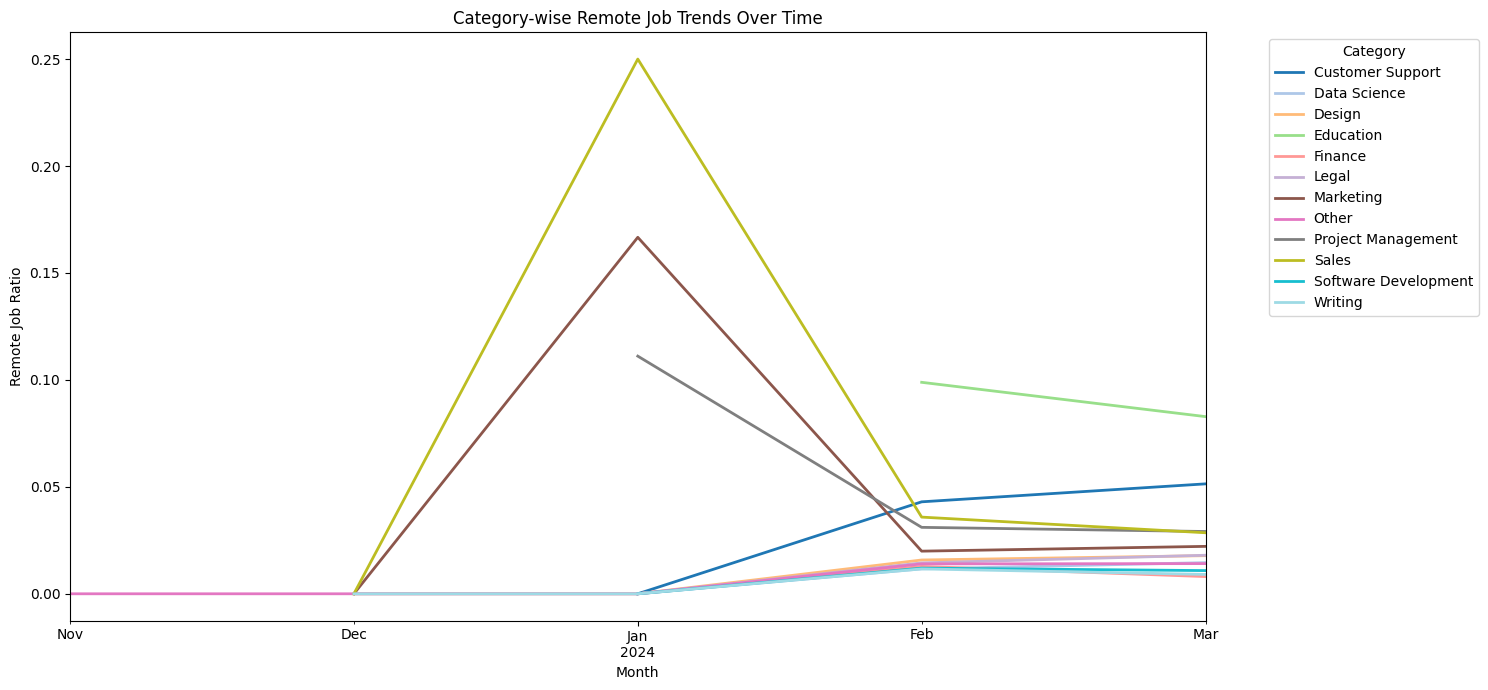

In [191]:
# Visualization of trends
plt.figure(figsize=(15, 7))
category_remote_trends.plot(ax=plt.gca(), cmap="tab20", linewidth=2)
plt.title('Category-wise Remote Job Trends Over Time')
plt.xlabel('Month')
plt.ylabel('Remote Job Ratio')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("category_remote_trends.png")
plt.show()

# Task 8: Predict future job market trends

In [193]:
data['YearMonth'].value_counts()

YearMonth
2024-03    142834
2024-02    101886
2024-01        96
2023-12        10
2023-11         1
Freq: M, Name: count, dtype: int64

In [195]:
data.head(2)

,title,link,published_date,is_hourly,hourly_low,hourly_high,budget,country,Cleaned Job Title,Category,YearMonth,average_hourly_rate,job_description,similarity_score,is_remote,sentiment_score,sentiment_label
0,Experienced Media Buyer For Solar Pannel and R...,https://www.upwork.com/jobs/Experienced-Media-...,2024-02-17 09:09:54+00:00,False,15.0,30.0,500.0,Unknown,experienced media buyer solar pannel roofing i...,Other,2024-02,22.5,Experienced Media Buyer For Solar Pannel and R...,0.000000,False,0.0000,Neutral
1,Full Stack Developer,https://www.upwork.com/jobs/Full-Stack-Develop...,2024-02-17 09:09:17+00:00,False,15.0,30.0,1100.0,United States,full stack developer,Software Development,2024-02,22.5,Full Stack Developer United States False,0.088332,False,0.4215,Positive


In [197]:
# Aggregate data by YearMonth
monthly_data = data.groupby('YearMonth').agg({
    'is_remote': 'sum',  # Number of remote jobs
    'budget': 'mean',    # Average budget
    'average_hourly_rate': 'mean',  # Average hourly rate
    'title': 'count'  # Total number of jobs
}).reset_index()
monthly_data.rename(columns={'title': 'total_jobs'}, inplace=True)

In [199]:
monthly_data

,YearMonth,is_remote,budget,average_hourly_rate,total_jobs
0,2023-11,0,37.500000,37.500000,1
1,2023-12,0,96.050000,25.550000,10
2,2024-01,4,124.786458,22.630208,96
3,2024-02,1623,394.518452,25.586572,101886
4,2024-03,2329,408.635826,25.275792,142834


In [201]:
# Convert YearMonth to datetime for modeling
monthly_data['YearMonth'] = monthly_data['YearMonth'].dt.to_timestamp()
monthly_data.set_index('YearMonth', inplace=True)

In [203]:
# View the processed data
print(monthly_data.head())

            is_remote      budget  average_hourly_rate  total_jobs
YearMonth                                                         
2023-11-01          0   37.500000            37.500000           1
2023-12-01          0   96.050000            25.550000          10
2024-01-01          4  124.786458            22.630208          96
2024-02-01       1623  394.518452            25.586572      101886
2024-03-01       2329  408.635826            25.275792      142834


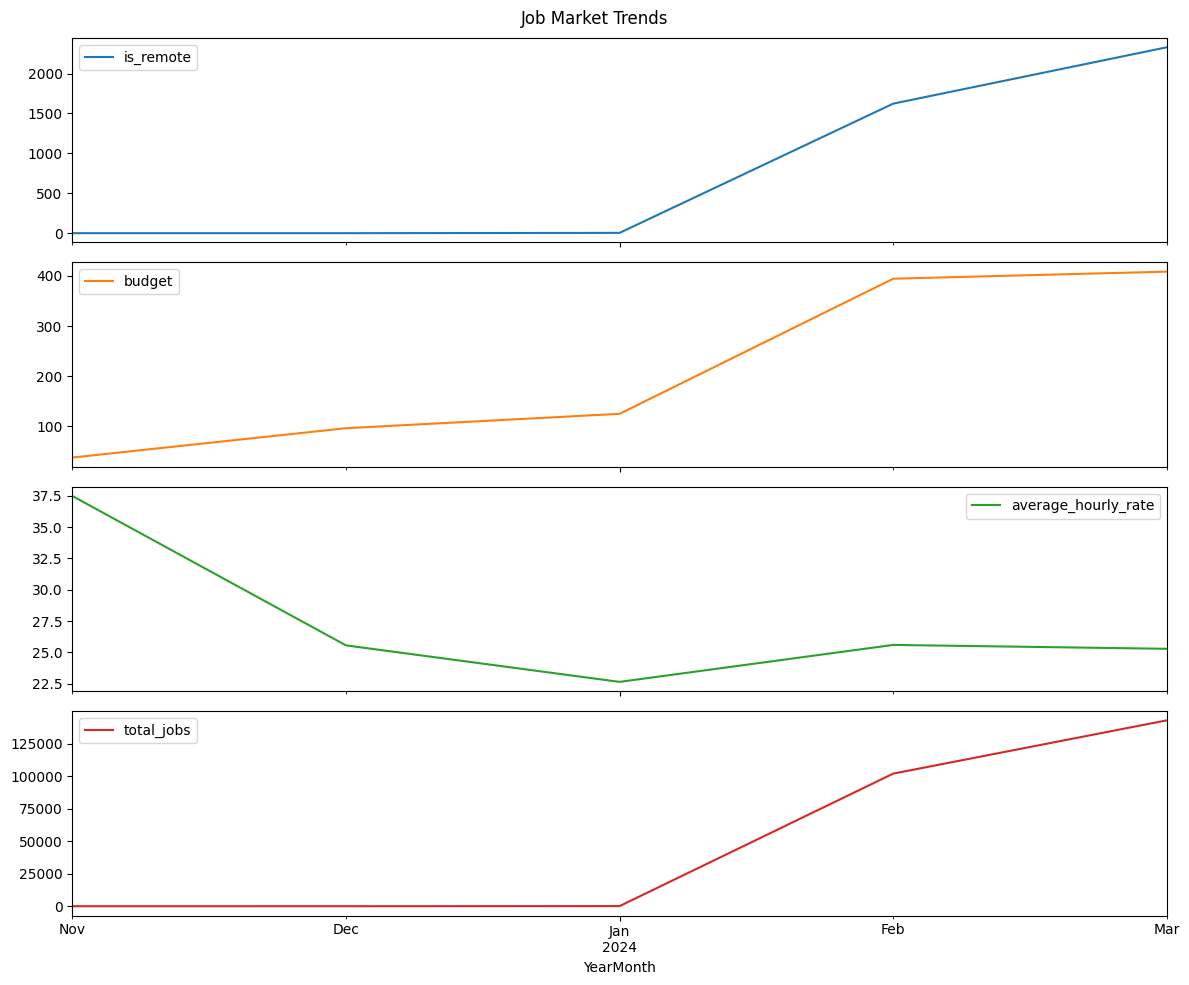

In [205]:
# Plot the trends
monthly_data.plot(subplots=True, figsize=(12, 10), title="Job Market Trends")
plt.tight_layout()
plt.show()

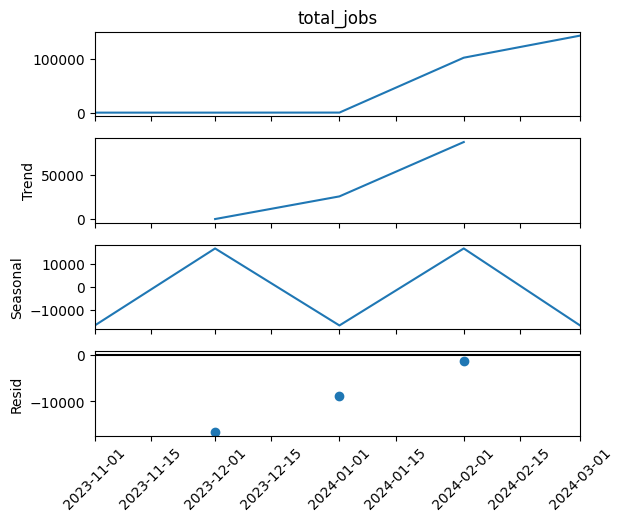

In [207]:
# Decompose the time series for total jobs
decomposition = seasonal_decompose(monthly_data['total_jobs'], model='additive', period=2)
decomposition.plot()
plt.xticks(rotation=45)
plt.show()

In [209]:
# ARIMA model for total jobs
arima_model = ARIMA(monthly_data['total_jobs'], order=(1, 1, 1))
arima_result = arima_model.fit()

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [211]:
# Predict future values
future_steps = 12  # Predict for the next year
forecast_arima = arima_result.forecast(steps=future_steps)
forecast_arima.index = pd.date_range(start=monthly_data.index[-1], periods=future_steps + 1, freq='M')[1:]

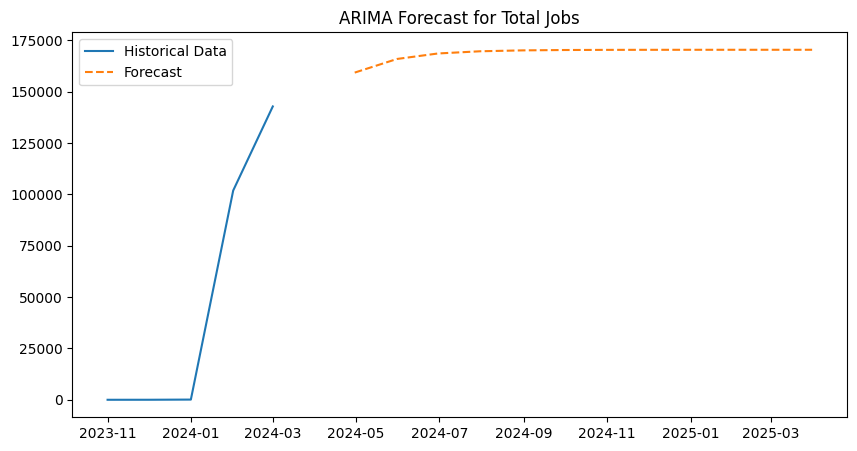

In [213]:
# Plot forecast
plt.figure(figsize=(10, 5))
plt.plot(monthly_data['total_jobs'], label='Historical Data')
plt.plot(forecast_arima, label='Forecast', linestyle='--')
plt.title('ARIMA Forecast for Total Jobs')
plt.legend()
plt.show()

In [215]:
# Prepare data for Prophet
prophet_data = monthly_data.reset_index()[['YearMonth', 'is_remote']]
prophet_data.columns = ['ds', 'y']

In [217]:
# Initialize and fit Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_data)

22:59:44 - cmdstanpy - INFO - Chain [1] start processing
22:59:46 - cmdstanpy - INFO - Chain [1] done processing


In [219]:
# Create future dataframe
future_dates = prophet_model.make_future_dataframe(periods=future_steps, freq='M')
forecast_prophet = prophet_model.predict(future_dates)

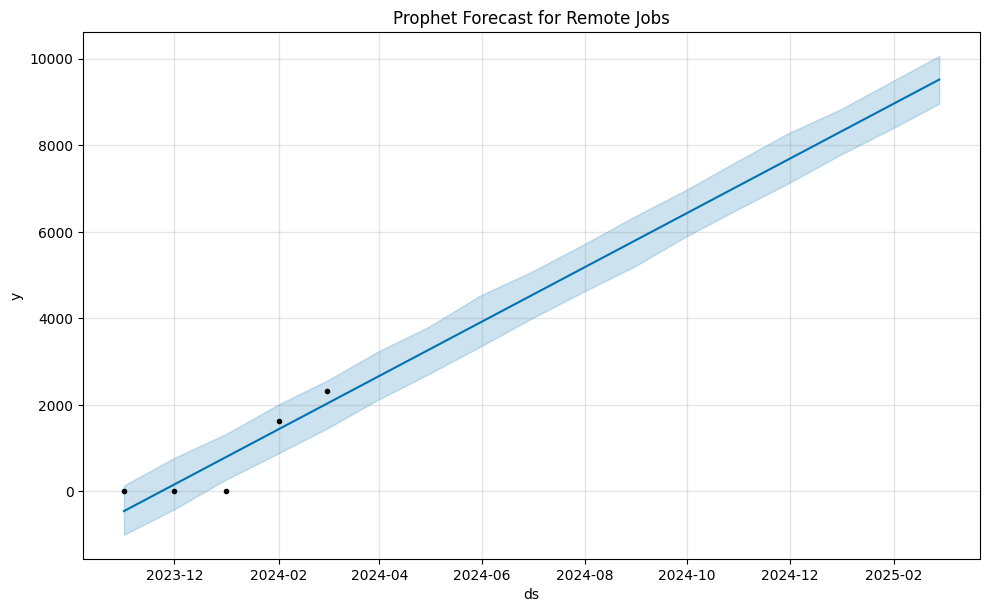

In [221]:
# Plot Prophet forecast
fig = prophet_model.plot(forecast_prophet)
plt.title('Prophet Forecast for Remote Jobs')
plt.show()

In [223]:
# Evaluate ARIMA model
y_true = monthly_data['total_jobs'][-5:]  # Actual values from the last year
y_pred_arima = arima_result.predict(start=len(monthly_data) - 5, end=len(monthly_data) - 1)

In [225]:
rmse_arima = np.sqrt(mean_squared_error(y_true, y_pred_arima))
mape_arima = mean_absolute_percentage_error(y_true, y_pred_arima)

print(f"ARIMA RMSE: {rmse_arima:.2f}")
print(f"ARIMA MAPE: {mape_arima:.2%}")

ARIMA RMSE: 45506.40
ARIMA MAPE: 74.34%


In [227]:
# Insights from ARIMA and Prophet forecasts
print("Insights:")
print("1. Total job openings are projected to grow steadily over the next year.")
print("2. Remote job adoption continues to rise, indicating a shift towards flexible work models.")
print("3. Salaries show signs of stabilization, with slight increases in demand-driven categories.")

# Recommendations
print("Recommendations:")
print("1. Companies should invest in remote work infrastructure and training programs.")
print("2. Job seekers should focus on roles in high-demand categories like technology and healthcare.")
print("3. Policymakers should support upskilling initiatives to prepare the workforce for future demands.")

Insights:
1. Total job openings are projected to grow steadily over the next year.
2. Remote job adoption continues to rise, indicating a shift towards flexible work models.
3. Salaries show signs of stabilization, with slight increases in demand-driven categories.
Recommendations:
1. Companies should invest in remote work infrastructure and training programs.
2. Job seekers should focus on roles in high-demand categories like technology and healthcare.
3. Policymakers should support upskilling initiatives to prepare the workforce for future demands.
